In [1]:
import numpy as np
import csv
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
#from tensorflow.examples.tutorials.mnist import input_data
from torch.autograd import Variable
import sklearn.metrics as metrics
import pickle
import os
import numpy.linalg as la
import random
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
from matplotlib import pyplot as plt
import time

In [2]:
with open('screen_info.txt','rb') as fl:
    t = pickle.load(fl)
fnames = t[0]
totf = t[1]
binf = t[2]
runfile = 0
fname = fnames[runfile]
bf = binf[runfile]

In [3]:
path = os.getcwd() + '/bioassay-datasets/'
p_fingerprints = []
c_fingerprints = []
labels = []
with open(path+fname+'red_train.csv') as csvfile:
    readcsv = csv.reader(csvfile)
    for row in readcsv:
        p_fingerprints.append(row[:bf])
        c_fingerprints.append(row[bf:-1])
        labels.append(row[-1])

In [4]:
print(np.asarray(p_fingerprints)[1:].shape)

p_fingerprints = np.asarray(p_fingerprints)[1:]
p_fingerprints = p_fingerprints.astype(int)
c_fingerprints = np.asarray(c_fingerprints)[1:]
c_fingerprints = c_fingerprints.astype(float)
#p2_fingerprints = np.ones(p_fingerprints.shape)
(no_examples , ip_dim) = p_fingerprints.shape
ip_dim2 = c_fingerprints.shape[1]
labels = labels[1:]
print(no_examples,ip_dim)
print(ip_dim2)
#p_fingerprints[(p_fingerprints==0)] = -1

(3423, 112)
(3423, 112)
32


In [5]:
labels2 = np.zeros((len(labels),1))
for i,l in enumerate(labels):
    if l=='Active':
        labels2[i] = 1
    else:
        labels2[i] = 0
labels2 = labels2.astype(int)

In [6]:
ind = np.arange(no_examples)
np.random.shuffle(ind)
p_fingerprints = p_fingerprints[ind]
c_fingerprints = c_fingerprints[ind]
labels2 = labels2[ind]

no_active_ele = (sum(labels2))
print(no_active_ele)

[48]


In [7]:
def get_train_batch(batch_size,validation_iter=0,binary=True):
    
    if validation_iter == 0: #no validation
        curr_data_size = no_examples
        labels_train = labels2
    else:
        curr_data_size = int(no_examples*0.8)
        interval_size = int(no_examples*0.2)
        
        if(val_iter==1):
            s_ind1 = int((validation_iter)*interval_size)
            end_ind1 = int((validation_iter+1)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        else:
            s_ind1 = 0
            end_ind1 = int((validation_iter)*interval_size)
            s_ind2 = int((validation_iter + 1) * interval_size)
            end_ind2 = int(no_examples)
        
        indices = range(s_ind1,end_ind1) + range(s_ind2,end_ind2)
        c_train_data = c_fingerprints[indices]
        p_train_data = p_fingerprints[indices]
        labels_train = labels2[indices]
                               
    samples = np.random.randint(low=0,high=curr_data_size,size=(batch_size,1))
    if binary == True:
        train_batch = p_fingerprints[samples].reshape(batch_size,ip_dim)
        train_batch = train_batch.astype(int)
    else:
        train_batch = c_fingerprints[samples].reshape(batch_size,ip_dim2)
        train_batch = train_batch.astype(float)
    
    train_batch = torch.cuda.FloatTensor(train_batch)
    train_batch = Variable(train_batch,requires_grad=False).cuda()
    target = Variable(torch.cuda.LongTensor(labels_train[samples]),requires_grad=False)
    target = target.view(batch_size,)
    return train_batch,target

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
train_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=True, download= True,
                       transform = transform)
test_set = dset.MNIST('/home/daiict/Desktop/udit/C-GAN./data' ,train=False, download=True,
                       transform = transform)

In [9]:
batch_size = 96
#ip_dim = 28*28
z_dim = 2

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,shuffle=True)
print len(train_loader), len(test_loader)

625 105


In [11]:
class encoder(nn.Module):
    def __init__(self):
        super(encoder,self).__init__()
        
        self.l1 = nn.Linear(ip_dim,800)
        self.l2 = nn.Linear(800,500)
        #self.l3 = nn.Linear(500,500)
        self.l41 = nn.Linear(500,100)
        self.l42 = nn.Linear(500,100)
        self.l51 = nn.Linear(100,z_dim)
        self.l52 = nn.Linear(100,z_dim)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        #x = F.leaky_relu(self.l3(x))
        x1 = F.leaky_relu(self.l41(x))
        x1 = self.l51(x1)
        x2 = F.leaky_relu(self.l42(x))
        x2 = self.l52(x2)
        
        return x1,x2

In [12]:
class decoder(nn.Module):
    def __init__(self):
        super(decoder,self).__init__()
        self.l1 = nn.Linear(z_dim,100)
        self.l2 = nn.Linear(100,500)
        self.l3 = nn.Linear(500,500)
        self.l4 = nn.Linear(500,ip_dim)
        
    def forward(self,x):
        
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = F.leaky_relu(self.l3(x))
        x = F.tanh(self.l4(x))
        
        return x

In [13]:
cuda = True
if(cuda):
    E = encoder().cuda()
    D = decoder().cuda()
else:
    E = encoder()
    D = decoder()

In [14]:
def clear_grad():
    E.zero_grad()
    D.zero_grad()

In [15]:
E_optim = optim.Adam(E.parameters(),lr = 1e-3)
D_optim = optim.Adam(D.parameters(),lr = 1e-3)

In [16]:
epochs = 10
kl_track= []
gen_track = []
for ep in range(2,epochs):
    #for idx,(x,label) in enumerate(train_loader):
    if(1==1):
        x,target = get_train_batch(batch_size,validation_iter = 0)
        
        if(cuda):
        #    x = Variable(x.cuda())
            z = Variable(torch.randn(batch_size,z_dim)).cuda()
        else:
         #   x = Variable(x)
            z = Variable(torch.randn(batch_size,z_dim))            
        #x = x.view(batch_size,28*28)
        
        
        mu,logvar = E(x)
        sig = torch.sqrt(torch.exp(logvar))
        zhat = mu + torch.mul(z,sig)
        xhat = D(zhat)
        
        if(ep%2==0):
            gen_loss = nn.MSELoss()(xhat,x)
            gen_loss.backward(retain_graph = True)
            D_optim.step()
            E_optim.step()
            clear_grad()
        
        ## KL Loss ##
        
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        # Normalise by same number of elements as in reconstruction
        KLD /= batch_size
        
        KLD.backward()
        E_optim.step()
        clear_grad()
        
    print gen_loss.data[0],KLD.data[0]
    kl_track.append(KLD.data[0])
    gen_track.append(gen_loss.data[0])
    
    if(ep%10==0):
#         z = Variable(torch.randn(1,z_dim).cuda())
#         op = D(z).view(28,28)
#         op = op.cpu().data.numpy()
#         plt.imshow(op)
#         plt.show()
        plt.plot(range(1,ep),kl_track)
        plt.title('kl loss')
        plt.show()
        plt.plot(range(1,ep),gen_track)
        plt.title('gen_loss')
        plt.show()

0.0738546475768 0.0017212126404
0.0738546475768 0.00421736575663
0.0616037100554 0.000896149955224
0.0616037100554 0.0020865581464
0.0602940320969 0.000739409297239
0.0602940320969 0.000402118719649
0.0557514987886 0.00034958528704
0.0557514987886 0.000274636491667


0.890846014023


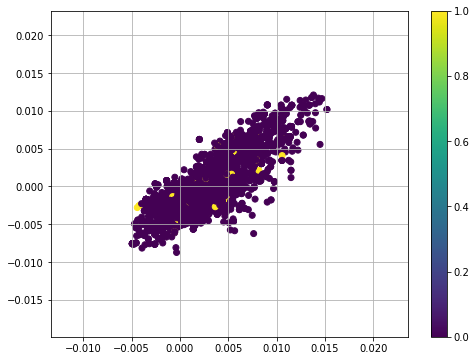

In [25]:
tic = time.time()
z_encoded,sig = E(Variable(torch.cuda.FloatTensor(p_fingerprints)))
toc = time.time()
print(toc-tic)

z_mu = z_encoded.cpu().data.numpy()

plt.figure(figsize=(8, 6)) 
plt.scatter(z_mu[:, 0], z_mu[:, 1], c=labels2)
plt.colorbar()
plt.grid()
plt.show()

In [29]:
labels2.min()

0

In [18]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.l1 = nn.Linear(z_dim,300)
        self.l2 = nn.Linear(300,300)
        self.l3 = nn.Linear(300,300)
        self.l4 = nn.Linear(300,100)
        self.l5 = nn.Linear(100,2)
        
    def forward(self,x):
        x = F.selu(self.l1(x))
        x = F.selu(self.l2(x))
        x = F.selu(self.l3(x))
        x = F.relu(self.l4(x))
        x = (self.l5(x))
        
        return x

In [19]:
def sample_z(size):
    ind = torch.cuda.LongTensor(torch.randperm(no_examples)[:size].numpy())
    return z_encoded[ind], Variable(torch.cuda.LongTensor(labels2)[ind],requires_grad = False)

In [20]:
def gen_disc_model(w):
    d = Discriminator().cuda()
    d_optim = optim.Adam(d.parameters(),lr=1e-4,weight_decay=1e-2)
    d = train_disc(d,d_optim,w)
    return d

In [21]:
def train_disc(d,d_optim,w):
    for ep in range(2000):
        d_optim.zero_grad()
        x,true_l = sample_z(batch_size)
        true_l = true_l.view(true_l.size()[0],)
        p_labels = d(x)
        weights = torch.Tensor([1,w]).cuda()
        criteria = nn.CrossEntropyLoss(weight=weights)
        true_l = true_l.type(torch.cuda.LongTensor)
        loss = criteria(p_labels,true_l)
        loss.backward(retain_graph=True)
        d_optim.step()
        
        if(ep%50==49):
            print(loss.data[0])
            
    return d

In [22]:
weights = np.linspace(25,50,5)
for w in weights:
    print("w: ",w)
    d = gen_disc_model(w)
    train_op = d(z_encoded).cpu().data.numpy()
    train_op = np.argmax(train_op,axis=1)
    cf = metrics.confusion_matrix(labels2,train_op)
    [tn, fp, fn, tp]  = cf.ravel()
    print('tn, fp, fn, tp: ',cf.ravel())

('w: ', 25.0)
0.219247221947
0.302901953459
0.663772463799
0.668787658215
0.521944105625
0.511873781681
0.520409464836
0.826178491116
0.250100910664
0.322393119335
0.515959084034
0.72384005785
0.511911571026
0.249573364854
0.513311326504
0.69628995657
0.684770166874
0.808147728443
0.271521180868
0.305563151836
0.237576186657
0.513569772243
0.519937515259
0.511732280254
0.24240757525
0.673063337803
0.666736960411
0.312711566687
0.259923994541
0.707462966442
0.668131172657
0.513441264629
0.786298453808
0.512489914894
0.519451677799
0.689434409142
0.519111275673
0.513040721416
0.906829178333
0.797654211521
('tn, fp, fn, tp: ', array([3375,    0,   48,    0]))
('w: ', 31.25)
0.855556845665
0.561686098576
0.587833940983
0.569924414158


KeyboardInterrupt: 

In [ ]:
z_encoded.dtype